# EDA Tugas Besar IF5153 - Kelompok NoLeP

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
df = pd.read_csv('https://drive.google.com/uc?id=1_zcMlbdDNZ93FRRS-pmnD5j10mfUu3ke', encoding='latin-1')
df_recommendation = pd.read_csv('https://drive.google.com/uc?id=1eX3v3E7YR-faYm7tXWzCsZH998oOsIqC', encoding='latin-1')

## Data Checking

In [5]:
print("Jumlah data:", len(df))
print("\nContoh data:\n")
display(df.sample(5))

Jumlah data: 6661

Contoh data:



,Patient_comment,Patient_Category
1246,I'm having a hard time hearing.,Ear ache
4911,There are lots of hairs on my pillow in the mo...,Hair falling out
2050,I can't move my head up and down.,Neck pain
1017,"I think there's something wrong with my wound,...",Infected wound
4871,I have a cut that has become red and oozes puss.,Infected wound


In [4]:
print("Jumlah data:", len(df_recommendation))
print("\nContoh data:\n")
display(df_recommendation.sample(5))

Jumlah data: 100

Contoh data:



,Symptoms_comment,Causes_and_Disease,Fetched_recommendation,Medicine_recommendation
73,"These past few days, Anxiety, Palpitations ha...","Based on the symptoms, the likely cause is Str...",Disease: PREMENSTRUAL SYNDROME\nTreatment: tre...,"Given the focus on anxiety, if symptoms are se..."
6,"I've been experiencing Chest Pain, Dizziness, ...","Clinically, this pattern points toward High Bl...",Disease: CHRONIC KIDNEY DISEASE\nTreatment: tr...,Target blood pressure should be rigorously man...
20,"Lately, I've noticed symptoms like Fatigue, We...","This presentation aligns with Anemia, often se...",Disease: IRON DEFICIENCY ANAEMIA\nTreatment: t...,The primary treatment involves Oral Iron Thera...
79,"I started feeling e Nausea, Vomiting, and it d...","The symptoms suggest Food Poisoning, and the p...",Disease: VOMITING\nTreatment: treatment\nï· H...,Initial management focuses on preventing dehyd...
17,"These past few days, Fever, Sore Throat have b...","Clinically, this pattern points toward Viral I...",Disease: CHRONIC TONSILLITIS\nTreatment: treat...,"For acute bacterial tonsillitis, a course of A..."


## Data Classification

### Distribusi Label

/tmp/ipython-input-4052584303.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Patient_Category', data=df, order=df['Patient_Category'].value_counts().index, palette="viridis")


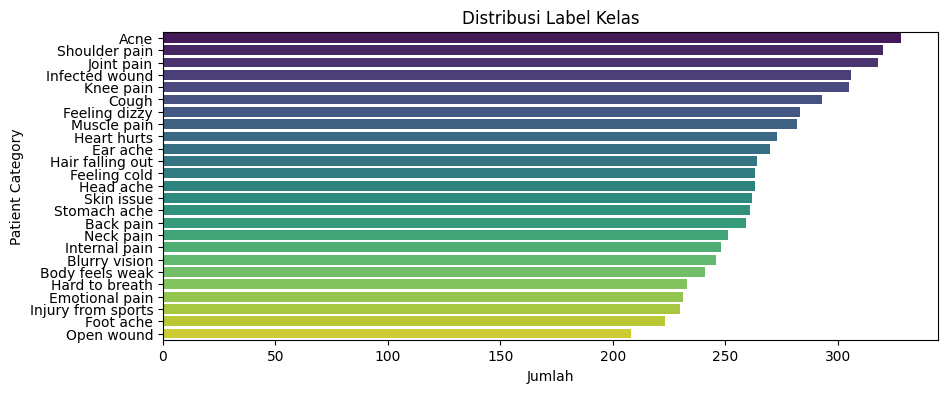

In [6]:
plt.figure(figsize=(10,4))
sns.countplot(y='Patient_Category', data=df, order=df['Patient_Category'].value_counts().index, palette="viridis")
plt.title("Distribusi Label Kelas")
plt.xlabel("Jumlah")
plt.ylabel("Patient Category")
plt.show()

### Preprocess Sederhana

In [7]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["Patient_comment"].apply(clean_text)

### Cek Panjang Teks

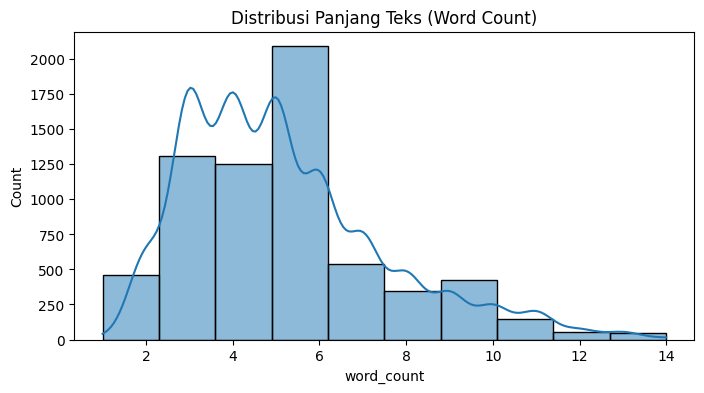

In [8]:
df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,4))
sns.histplot(df["word_count"], bins=10, kde=True)
plt.title("Distribusi Panjang Teks (Word Count)")
plt.show()

### Top Words per Label

In [9]:
def top_words_by_label(label):
    text = " ".join(df[df["Patient_Category"] == label]["clean_text"])
    words = text.split()
    counter = Counter(words)
    return counter.most_common(5)

unique_labels = df["Patient_Category"].unique()
top_words = {label: top_words_by_label(label) for label in unique_labels}
pd.DataFrame(top_words).T

,0,1,2,3,4
Emotional pain,"(feel, 152)","(sad, 62)","(pain, 59)","(cant, 36)","(like, 32)"
Hair falling out,"(hair, 278)","(falling, 111)","(lot, 43)","(brush, 29)","(coming, 29)"
Heart hurts,"(heart, 204)","(pain, 105)","(hurts, 79)","(feel, 77)","(chest, 55)"
Infected wound,"(infected, 130)","(cut, 108)","(wound, 106)","(red, 50)","(hand, 48)"
Foot ache,"(foot, 188)","(pain, 90)","(ache, 63)","(walk, 44)","(cant, 38)"
Shoulder pain,"(shoulder, 243)","(pain, 170)","(feel, 73)","(try, 49)","(move, 44)"
Injury from sports,"(sports, 56)","(playing, 53)","(injured, 50)","(pain, 42)","(soccer, 41)"
Skin issue,"(skin, 167)","(rash, 60)","(red, 39)","(itching, 29)","(feel, 28)"
Stomach ache,"(stomach, 213)","(pain, 97)","(feel, 65)","(eat, 48)","(ache, 38)"
Knee pain,"(knee, 227)","(pain, 101)","(walk, 60)","(hurts, 54)","(feel, 53)"


## Data Recommendation Generation

### Jumlah Kata

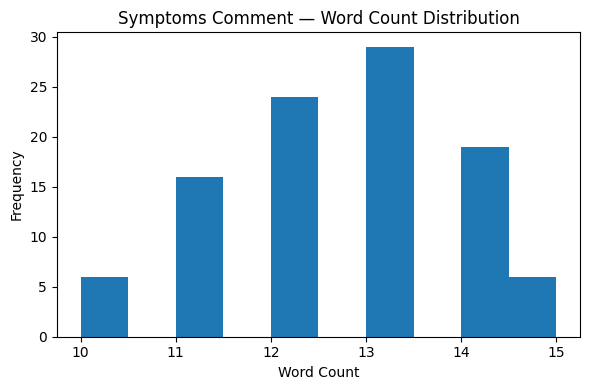

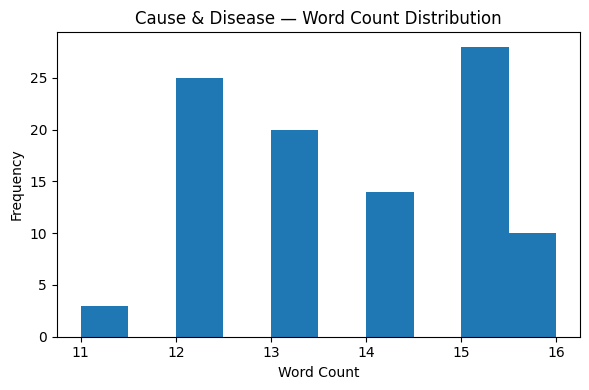

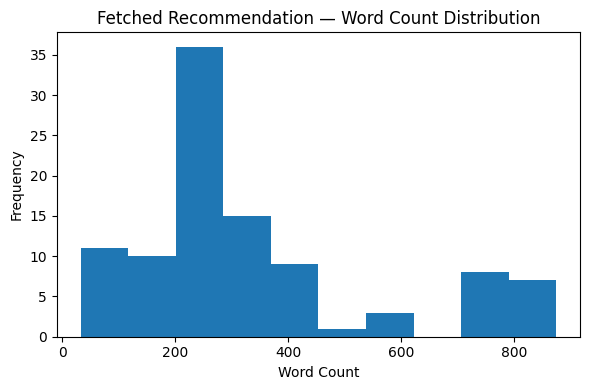

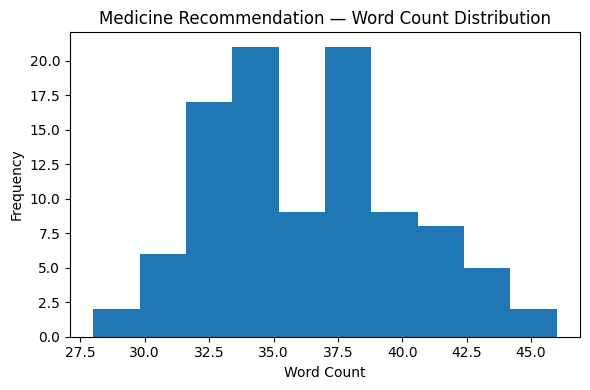

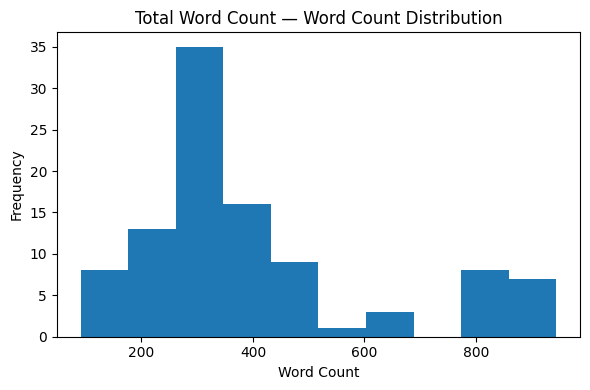

/tmp/ipython-input-2293606027.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_recommendation[c] for c in cols.keys()], labels=list(cols.values()))


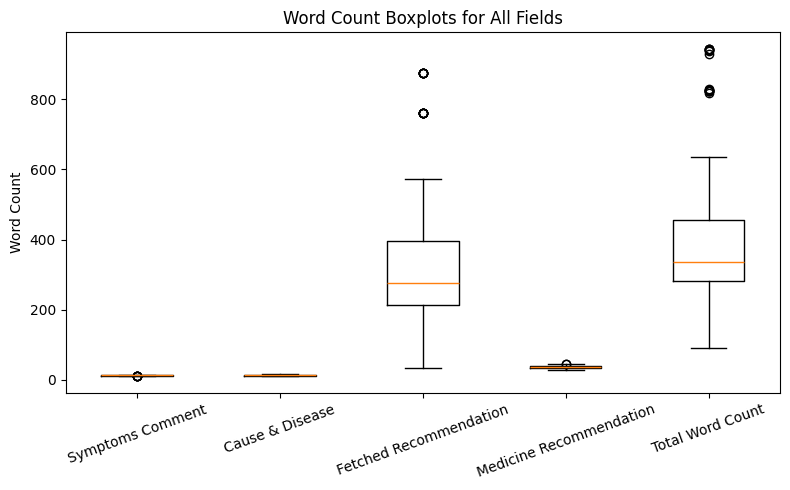

In [16]:
def count_words(text):
    if pd.isna(text):
        return 0
    return len(str(text).split())

df_recommendation['symptoms_word_count'] = df_recommendation['Symptoms_comment'].apply(count_words)
df_recommendation['cause_word_count'] = df_recommendation['Causes_and_Disease'].apply(count_words)
df_recommendation['fetched_word_count'] = df_recommendation['Fetched_recommendation'].apply(count_words)
df_recommendation['medicine_word_count'] = df_recommendation['Medicine_recommendation'].apply(count_words)
df_recommendation['total_word_count'] = df_recommendation['symptoms_word_count'] + df_recommendation['cause_word_count'] + df_recommendation['fetched_word_count'] + df_recommendation['medicine_word_count']

max_symptoms_words = df_recommendation['symptoms_word_count'].max()
max_cause_words = df_recommendation['cause_word_count'].max()
max_fetched_words = df_recommendation['fetched_word_count'].max()
max_medicine_words = df_recommendation['medicine_word_count'].max()
max_total_words = df_recommendation['total_word_count'].max()

cols = {
    "symptoms_word_count": "Symptoms Comment",
    "cause_word_count": "Cause & Disease",
    "fetched_word_count": "Fetched Recommendation",
    "medicine_word_count": "Medicine Recommendation",
    "total_word_count": "Total Word Count"
}

for col, title in cols.items():
    plt.figure(figsize=(6,4))
    plt.hist(df_recommendation[col].dropna())
    plt.title(f"{title} — Word Count Distribution")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(8,5))
plt.boxplot([df_recommendation[c] for c in cols.keys()], labels=list(cols.values()))
plt.title("Word Count Boxplots for All Fields")
plt.ylabel("Word Count")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()